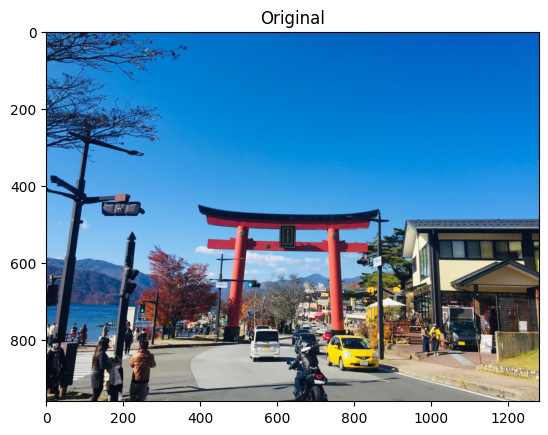

Window size:5 Block size:(2,2), Time processing on GPU without shared memory: 1.2011439800262451s


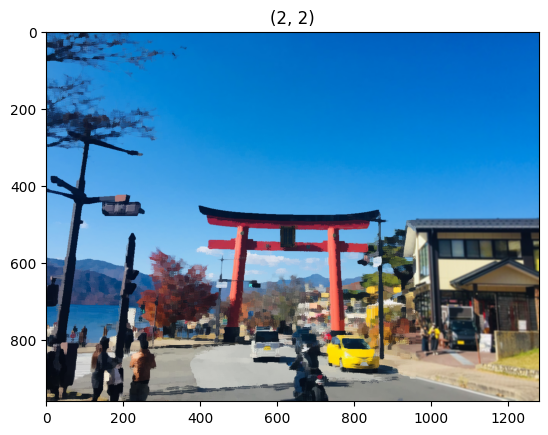

Window size:5 Block size:(4,4), Time processing on GPU without shared memory: 0.0011518001556396484s


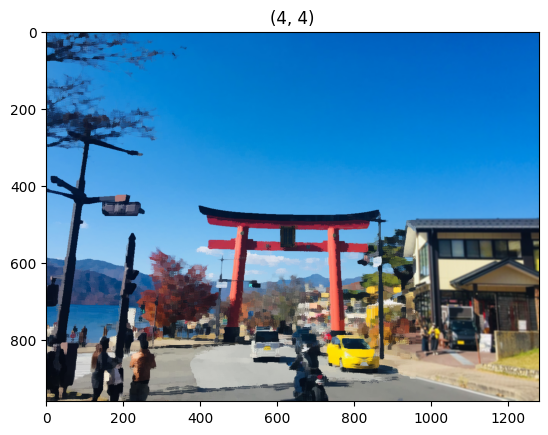

Window size:5 Block size:(8,8), Time processing on GPU without shared memory: 0.001049041748046875s


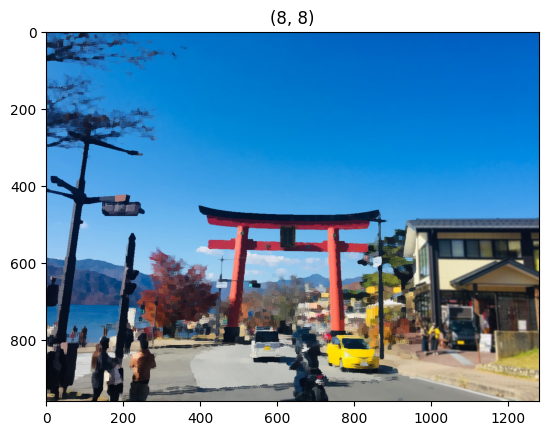

Window size:5 Block size:(2,2), Time processing on GPU with shared memory: 0.8776934146881104s


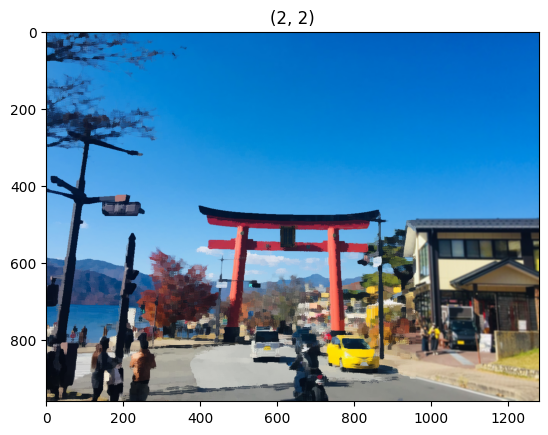

Window size:5 Block size:(4,4), Time processing on GPU with shared memory: 0.0013272762298583984s


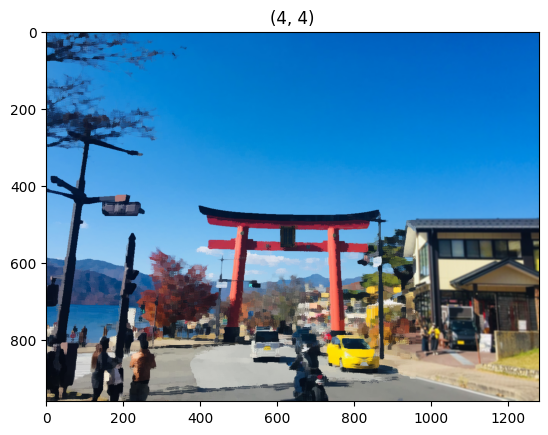

Window size:5 Block size:(8,8), Time processing on GPU with shared memory: 0.0022156238555908203s


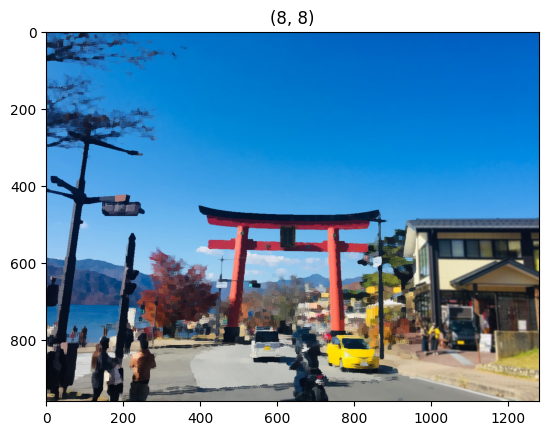

Window size:6 Block size:(2,2), Time processing on GPU without shared memory: 0.0012507438659667969s


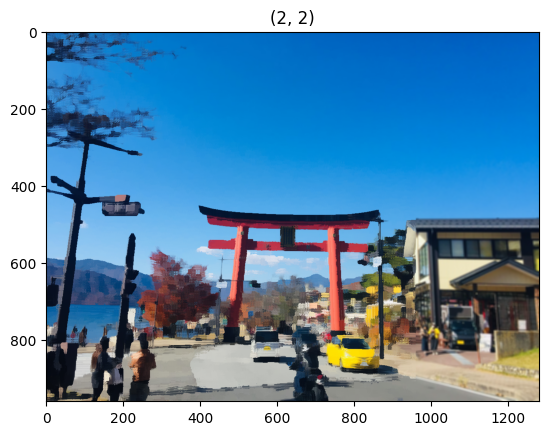

Window size:6 Block size:(4,4), Time processing on GPU without shared memory: 0.0011663436889648438s


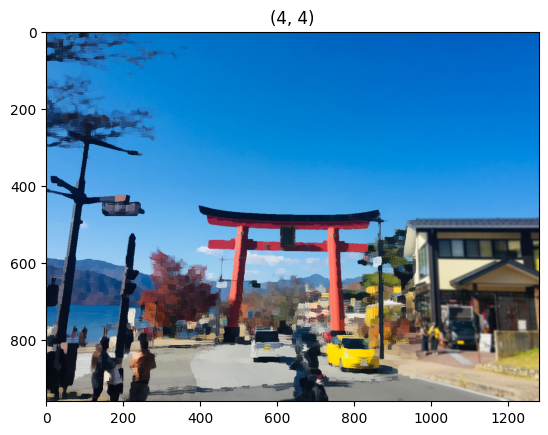

Window size:6 Block size:(8,8), Time processing on GPU without shared memory: 0.001226186752319336s


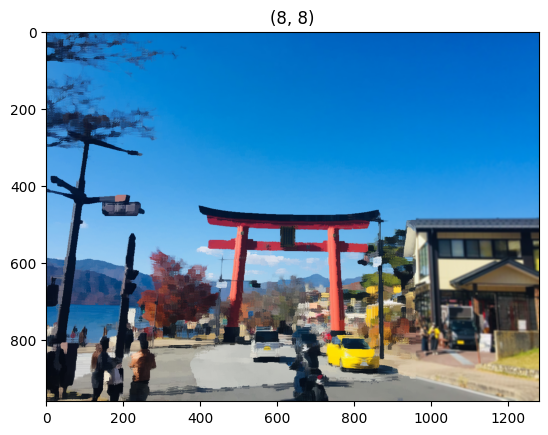

Window size:6 Block size:(2,2), Time processing on GPU with shared memory: 0.0011284351348876953s


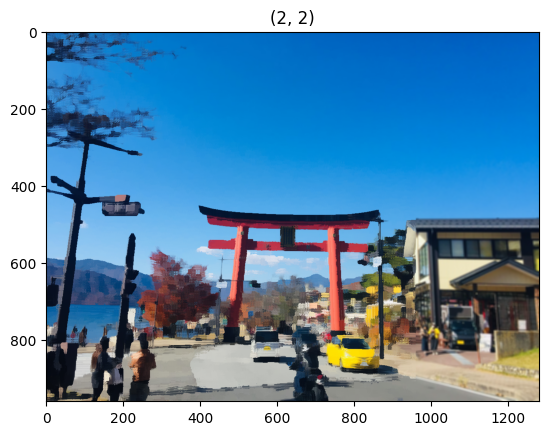

Window size:6 Block size:(4,4), Time processing on GPU with shared memory: 0.0004601478576660156s


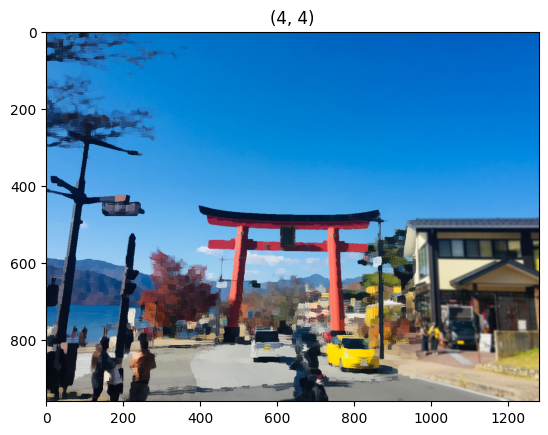

Window size:6 Block size:(8,8), Time processing on GPU with shared memory: 0.0004858970642089844s


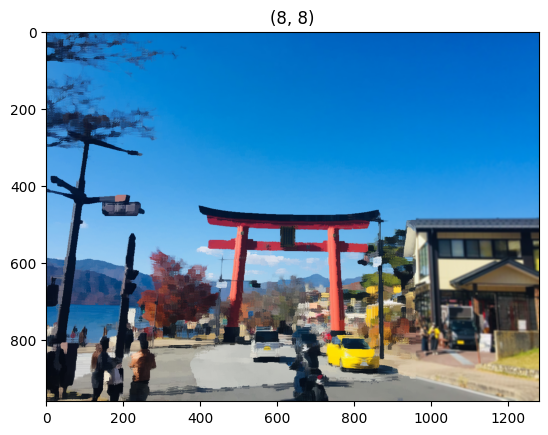

Window size:7 Block size:(2,2), Time processing on GPU without shared memory: 0.0006759166717529297s


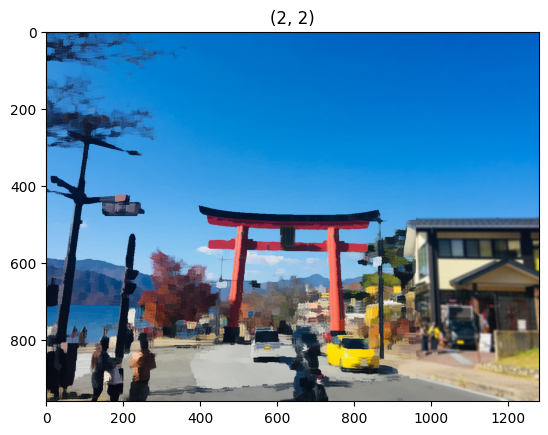

Window size:7 Block size:(4,4), Time processing on GPU without shared memory: 0.0011630058288574219s


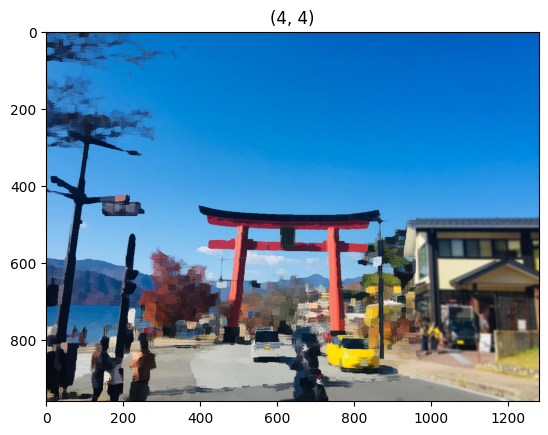

Window size:7 Block size:(8,8), Time processing on GPU without shared memory: 0.004990100860595703s


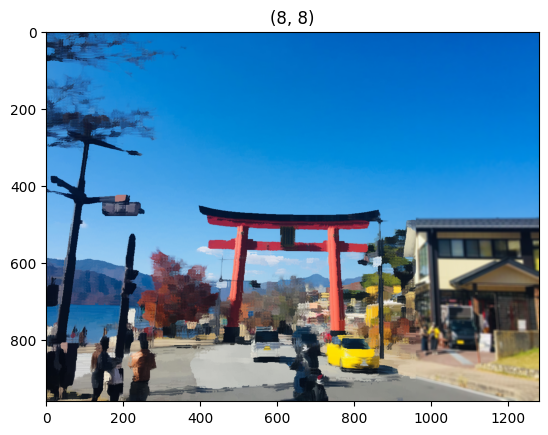

Window size:7 Block size:(2,2), Time processing on GPU with shared memory: 0.004568815231323242s


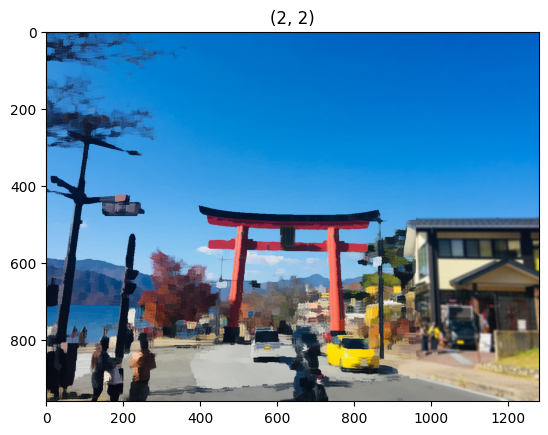

Window size:7 Block size:(4,4), Time processing on GPU with shared memory: 0.0011186599731445312s


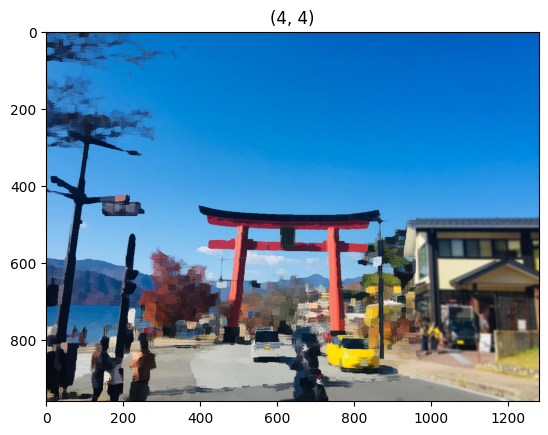

Window size:7 Block size:(8,8), Time processing on GPU with shared memory: 0.0010519027709960938s


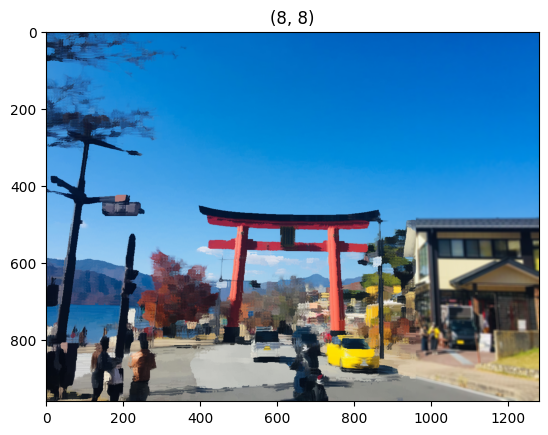

Window size:8 Block size:(2,2), Time processing on GPU without shared memory: 0.0011794567108154297s


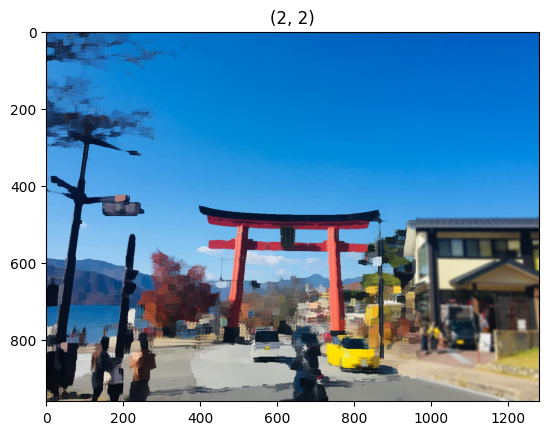

Window size:8 Block size:(4,4), Time processing on GPU without shared memory: 0.0010099411010742188s


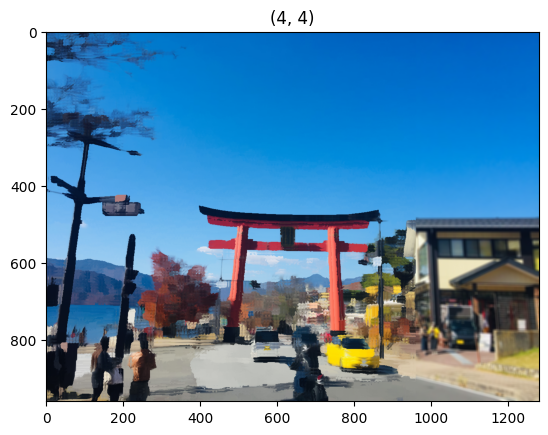

Window size:8 Block size:(8,8), Time processing on GPU without shared memory: 0.0010528564453125s


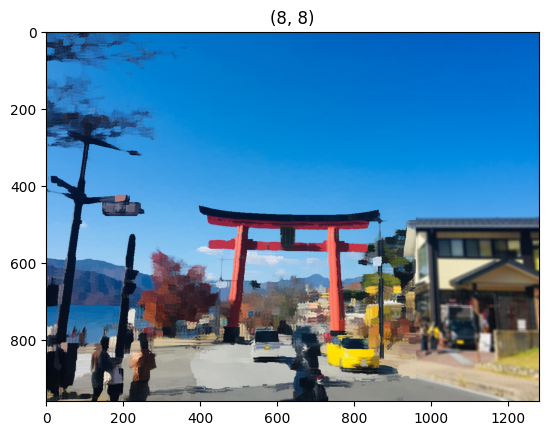

Window size:8 Block size:(2,2), Time processing on GPU with shared memory: 0.0012369155883789062s


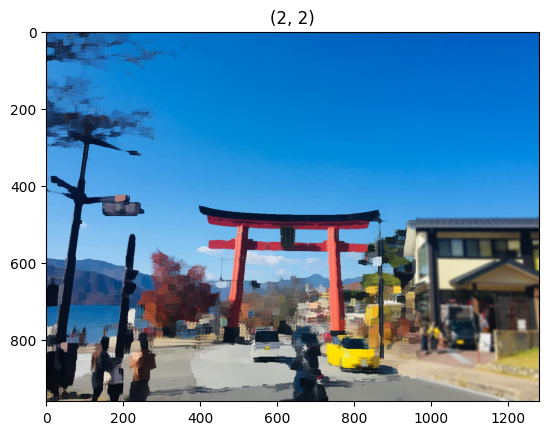

Window size:8 Block size:(4,4), Time processing on GPU with shared memory: 0.0009870529174804688s


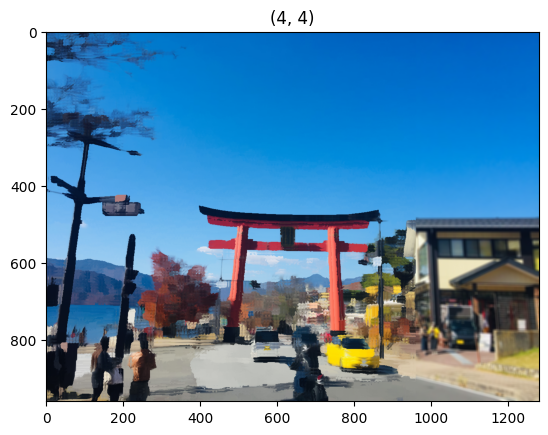

Window size:8 Block size:(8,8), Time processing on GPU with shared memory: 0.0011737346649169922s


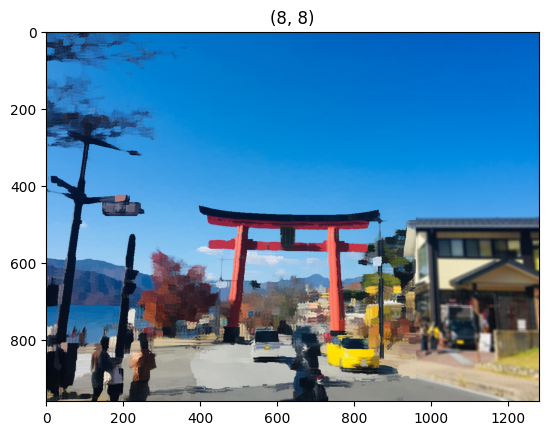

In [ ]:
import numba
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda, types
from numba import jit
from matplotlib.image import imread
import math
import time
import cv2

# Load an image from a file
image_path = 'kuwahara.jpg'
image = imread(image_path)
plt.imshow(image), plt.title('Original')
plt.show()


# rgb to hsv
@cuda.jit
def rgb_to_hsv(src, dst):
    x, y = cuda.grid(2)
    if y < dst.shape[0] and x < dst.shape[1]:
        max_value = max(src[y, x, 0], src[y, x, 1], src[y, x, 2])
        min_value = min(src[y, x, 0], src[y, x, 1], src[y, x, 2])
        delta = max_value - min_value
        if delta == 0:
            h_value = 0
        elif max_value == src[y, x, 0]:
            h_value = 60 * (((src[y, x, 1] - src[y, x, 2]) / delta) % 6)
        elif max_value == src[y, x, 1]:
            h_value = 60 * (((src[y, x, 2] - src[y, x, 0]) / delta) + 2)
        elif max_value == src[y, x, 2]:
            h_value = 60 * (((src[y, x, 0] - src[y, x, 1]) / delta) + 4)

        if max_value == 0:
            s_value = 0
        else:
            s_value = delta / max_value
        v_value = max_value
        dst[y, x, 0] = h_value
        dst[y, x, 1] = s_value
        dst[y, x, 2] = v_value

@cuda.jit
def kuwahara_filter_without_shared(input_image, output_image,hsv, window_size):
    x, y = cuda.grid(2)
    if x < input_image.shape[0] and y < input_image.shape[1]:
        mean_variances = cuda.local.array((4,  9), numba.float32)

        for q in range(4):
            # Define the region for the current quadrant
            x_start, x_end, y_start, y_end = 0, 0, 0, 0

            if q == 0:
                x_start, x_end, y_start, y_end = x, x + window_size, y, y + window_size
            elif q == 1:
                x_start, x_end, y_start, y_end = x, x + window_size, y - window_size, y
            elif q == 2:
                x_start, x_end, y_start, y_end = x - window_size, x, y, y + window_size
            else:
                x_start, x_end, y_start, y_end = x - window_size, x, y - window_size, y

            # Extract the neighborhood for the current quadrant
            neighborhood_rgb = input_image[x_start:x_end, y_start:y_end, :]
            neighborhood = hsv[x_start:x_end, y_start:y_end, :]

            # Calculate the mean and variance for each channel
            for c in range(0,3):
                channel_values = neighborhood[:, :, c]
                channel_values_rgb = neighborhood_rgb[:, :, c]
                mean = 0.0
                mean_rgb = 0.0
                variance = 0.0
                size = neighborhood.shape[0]*neighborhood.shape[1]
                # Calculate the mean
                for i in range(neighborhood.shape[0]):
                    for j in range(neighborhood.shape[1]):
                        mean += channel_values[i, j]

                mean //= size


                for i in range(neighborhood_rgb.shape[0]):
                    for j in range(neighborhood_rgb.shape[1]):
                        mean_rgb += channel_values_rgb[i, j]

                mean_rgb //= size


                # Calculate the variance
                for i in range(neighborhood.shape[0]):
                    for j in range(neighborhood.shape[1]):
                        variance += (channel_values[i, j] - mean) ** 2

                variance /= size
                mean_variances[q, c] = variance
                mean_variances[q, c +3] = mean
                mean_variances[q, c +6] = mean_rgb

        # Determine the quadrant with the minimum variance
        min_variance_quadrant = 0
        min_variance =math.sqrt( mean_variances[0, 0] + mean_variances[0, 1] + mean_variances[0, 2])

        for q in range(1, 4):
            nn =math.sqrt( mean_variances[q, 0] + mean_variances[q, 1] + mean_variances[q, 2])
            if nn < min_variance:
                min_variance_quadrant = q
                min_variance = nn

        # Set the pixel value to the mean of the channel in the minimum variance quadrant
        output_image[x, y, 0] = mean_variances[min_variance_quadrant, 6]
        output_image[x, y, 1] = mean_variances[min_variance_quadrant, 7]
        output_image[x, y, 2] = mean_variances[min_variance_quadrant, 8]



@cuda.jit
def kuwahara_filter_with_shared(input_image, output_image,hsv):
    x, y = cuda.grid(2)
    shared = cuda.shared.array(1, dtype=np.float32)
    window_size = shared[0]

    if x < input_image.shape[0] and y < input_image.shape[1]:
        mean_variances = cuda.local.array((4,  9), numba.float32)

        for q in range(4):
            # Define the region for the current quadrant
            x_start, x_end, y_start, y_end = 0, 0, 0, 0

            if q == 0:
                x_start, x_end, y_start, y_end = x, x + window_size, y, y + window_size
            elif q == 1:
                x_start, x_end, y_start, y_end = x, x + window_size, y - window_size, y
            elif q == 2:
                x_start, x_end, y_start, y_end = x - window_size, x, y, y + window_size
            else:
                x_start, x_end, y_start, y_end = x - window_size, x, y - window_size, y

            # Extract the neighborhood for the current quadrant
            neighborhood_rgb = input_image[x_start:x_end, y_start:y_end, :]
            neighborhood = hsv[x_start:x_end, y_start:y_end, :]

            # Calculate the mean and variance for each channel
            for c in range(0,3):
                channel_values = neighborhood[:, :, c]
                channel_values_rgb = neighborhood_rgb[:, :, c]
                mean = 0.0
                mean_rgb = 0.0
                variance = 0.0
                size = neighborhood.shape[0]*neighborhood.shape[1]
                # Calculate the mean
                for i in range(neighborhood.shape[0]):
                    for j in range(neighborhood.shape[1]):
                        mean += channel_values[i, j]

                mean //= size


                for i in range(neighborhood_rgb.shape[0]):
                    for j in range(neighborhood_rgb.shape[1]):
                        mean_rgb += channel_values_rgb[i, j]

                mean_rgb //= size


                # Calculate the variance
                for i in range(neighborhood.shape[0]):
                    for j in range(neighborhood.shape[1]):
                        variance += (channel_values[i, j] - mean) ** 2

                variance /= size
                mean_variances[q, c] = variance
                mean_variances[q, c +3] = mean
                mean_variances[q, c +6] = mean_rgb

        # Determine the quadrant with the minimum variance
        min_variance_quadrant = 0
        min_variance =math.sqrt( mean_variances[0, 0] + mean_variances[0, 1] + mean_variances[0, 2])

        for q in range(1, 4):
            nn =math.sqrt( mean_variances[q, 0] + mean_variances[q, 1] + mean_variances[q, 2])
            if nn < min_variance:
                min_variance_quadrant = q
                min_variance = nn

        # Set the pixel value to the mean of the channel in the minimum variance quadrant
        output_image[x, y, 0] = mean_variances[min_variance_quadrant, 6]
        output_image[x, y, 1] = mean_variances[min_variance_quadrant, 7]
        output_image[x, y, 2] = mean_variances[min_variance_quadrant, 8]


@cuda.jit
def setting_share_memory(window_size):
    shared = cuda.shared.array(1, dtype=np.float32)
    shared[0] = window_size
    cuda.syncthreads()

# Implement with GPU
blockSizes = [(2,2),(4,4),(8, 8)]
times_gpu = []
size_test = [5,6,7,8]
window_size = 5
image_height, image_width, _ = image.shape


devSrc = cuda.to_device(image)
devDst = cuda.device_array((image_height, image_width, 3), np.uint8)
hsv = cuda.device_array((image_height, image_width, 3), np.uint8)

for window_size in size_test:

  # Without shared memory
  for block_size in blockSizes:

    grid_size_x = (image_height + block_size[0] - 1) // block_size[0]
    grid_size_y = (image_width + block_size[1] - 1) // block_size[1]
    start_time_gpu = time.time()
    rgb_to_hsv[(grid_size_x, grid_size_y), block_size](devSrc, hsv)
    kuwahara_filter_without_shared[(grid_size_x, grid_size_y), block_size](devSrc, devDst, hsv, window_size)
    time_gpu = time.time() - start_time_gpu
    times_gpu.append(time_gpu)
    print(f"Window size:{window_size} Block size:({block_size[0]},{block_size[1]}), Time processing on GPU without shared memory: {time_gpu}s")
    hostDst = devDst.copy_to_host()
    kuwahara_filter_image = np.array(hostDst)
    plt.imsave(f'kuwahara_windowsize_{window_size}_blocksize_({block_size[0]},{block_size[1]})__without_sm.jpg', kuwahara_filter_image, cmap='gray')

    plt.title(block_size)
    plt.imshow(kuwahara_filter_image)
    plt.show()


  # With shared memory
  for block_size in blockSizes:

    grid_size_x = (image_height + block_size[0] - 1) // block_size[0]
    grid_size_y = (image_width + block_size[1] - 1) // block_size[1]
    start_time_gpu = time.time()

    setting_share_memory[(grid_size_x, grid_size_y), block_size](window_size)
    kuwahara_filter_with_shared[(grid_size_x, grid_size_y), block_size](devSrc, devDst, hsv)

    time_gpu = time.time() - start_time_gpu
    times_gpu.append(time_gpu)
    print(f"Window size:{window_size} Block size:({block_size[0]},{block_size[1]}), Time processing on GPU with shared memory: {time_gpu}s")
    hostDst = devDst.copy_to_host()
    kuwahara_filter_image = np.array(hostDst)
    plt.imsave(f'kuwahara_windowsize_{window_size}_blocksize_({block_size[0]},{block_size[1]})_with_sm.jpg', kuwahara_filter_image, cmap='gray')

    plt.title(block_size)
    plt.imshow(kuwahara_filter_image)
    plt.show()

